# DSI Capstone Project
## DrivenData: Box-Plots for Education

Uyen Truong

## Goal of the Competition:
The task is a multi-class-multi-label classification problem with the goal of attaching labels to the freeform text in budget line items. Each row in the budget has mostly free-form text features, except for two that are noted as float. Any of the fields may or may not be empty.

**Goal**: The goal is to predict a probability for each possible label in the dataset given a row of new data. Each of these probabilities goes in a separate column in the submission file. The submission must be 50064x104 where 50064 is the number of rows in the test dataset (excluding the header) and 104 is the number of columns (excluding a first column of row ids). The columns in the submission have the format : ColumnName__PossibleLabel

**Features/Predictors**:

- FTE (float) - If an employee, the percentage of full-time that the employee works.
- Facility_or_Department - If expenditure is tied to a department/facility, that department/facility.
- Function_Description - A description of the function the expenditure was serving.
- Fund_Description - A description of the source of the funds.
- Job_Title_Description - If this is an employee, a description of that employee's job title.
- Location_Description - A description of where the funds were spent.
- Object_Description - A description of what the funds were used for.
- Position_Extra - Any extra information about the position that we have.
- Program_Description - A description of the program that the funds were used for.
- SubFund_Description - More detail on Fund_Description
- Sub_Object_Description - More detail on Object_Description
- Text_1 - Any additional text supplied by the district.
- Text_2 - Any additional text supplied by the district.
- Text_3 - Any additional text supplied by the district.
- Text_4 - Any additional text supplied by the district.
- Total (float) - The total cost of the expenditure.

**Labels/Targets**


**Function**
Aides Compensation, Career & Academic Counseling, Communications, Curriculum Development, Data Processing & Information Services, Development & Fundraising, Enrichment, Extended Time & Tutoring, Facilities & Maintenance, Facilities Planning, Finance, Budget, Purchasing & Distribution, Food Services, Governance, Human Resources, Instructional Materials & Supplies, Insurance, Legal, Library & Media, NO_LABEL, Other Compensation, Other Non-Compensation, Parent & Community Relations, Physical Health & Services, Professional Development, Recruitment, Research & Accountability, School Administration, School Supervision, Security & Safety, Social & Emotional, Special Population Program Management & Support, Student Assignment, Student Transportation, Substitute Compensation, Teacher Compensation, Untracked Budget Set-Aside, Utilities

**Object_Type:**
Base Salary/Compensation,
Benefits,
Contracted Services,
Equipment & Equipment Lease,
NO_LABEL,
Other Compensation/Stipend,
Other Non-Compensation,
Rent/Utilities,
Substitute Compensation,
Supplies/Materials,
Travel & Conferences,

**Operating_Status:**
Non-Operating (If Non-Operating, all other labels must be NO LABEL),
Operating, Not PreK-12,
PreK-12 Operating,

**Position_Type:**
(Exec) Director,
Area Officers,
Club Advisor/Coach,
Coordinator/Manager,
Custodian,
Guidance Counselor,
Instructional Coach,
Librarian,
NO_LABEL,
Non-Position,
Nurse,
Nurse Aide,
Occupational Therapist,
Other,
Physical Therapist,
Principal,
Psychologist,
School Monitor/Security,
Sec/Clerk/Other Admin,
Social Worker,
Speech Therapist,
Substitute,
TA,
Teacher,
Vice Principal

**Pre_K:**
NO_LABEL,
Non PreK,
PreK,

**Reporting:**
NO_LABEL,
Non-School,
School,

**Sharing:**
Leadership & Management,
NO_LABEL,
School Reported,
School on Central Budgets,
Shared Services,

**Student_Type:**
Alternative,
At Risk,
ELL,
Gifted,
NO_LABEL,
Poverty,
PreK,
Special Education,
Unspecified,

**Use:**
Business Services,
ISPD,
Instruction,
Leadership,
NO_LABEL,
O&M,
Pupil Services & Enrichment,
Untracked Budget Set-Aside

## Part 1: EDA & Data Preprocessing 

In [17]:
budget_train = pd.read_csv('../data/school_budget_train.csv')

The training dataset consists of many null values. The graph below shows the percentage of missing values in each predictor column.

In [29]:
% %matplotlib inline

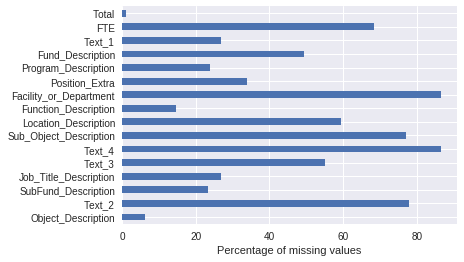

In [31]:
_ = (budget_train[predictors].isnull().sum()/budget_train[predictors].shape[0]*100).plot(kind='barh')
plt.xlabel('Percentage of missing values')

**For non-numerical columns:**
I decided to replace Null values in the columns with words with empty strings because this is a NLP classification problem, I thought that empty strings were the best replacements for nulls. In addition to null values, many columns also had "n/a" as values so I also replaced those with empty strings as well.

In [ ]:
for col in budget_df[word_predictors]:
    budget_df[col] = budget_df[word_predictors].loc[:,[col]].fillna(' ')
    
for col in budget_df[word_predictors]:
    budget_df[col] = budget_df[col].replace({"n/a": ' '})

**For numerical columns:**
I decided to replace Null values in the 'Total' column with the mean since there weren't many missing values.

For the 'FTE' column, almost 70% of the data were null values and some of the existing values were incorrect values since this column is only supposed to have values between 0-1. I found that there were more than 3000 values not in this range and was skewing the mean. Therefore, I used the np.clip function so that all values less than 0 becomes 0 and values greater than 1 becomes 1. After that, I filled in the missing values with the mean. 

In [ ]:
budget_df['Total'] = budget_df.loc[:,['Total']].fillna(budget_df['Total'].mean())

budget_df['FTE'] = np.clip(budget_df['FTE'],0,1)
budget_df['FTE'] = budget_df.loc[:,['FTE']].fillna(budget_df['FTE'].mean())

### EDA of target columns

Since this is a multi-class classication problem, I wanted to look at the class balance for each label/target column.

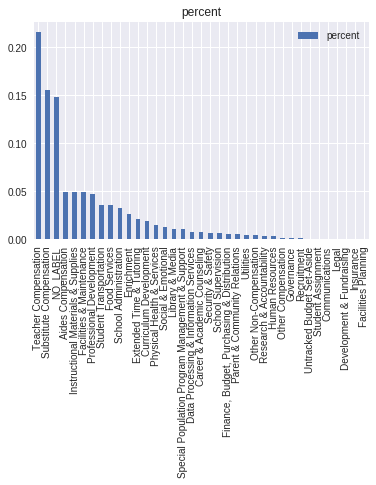

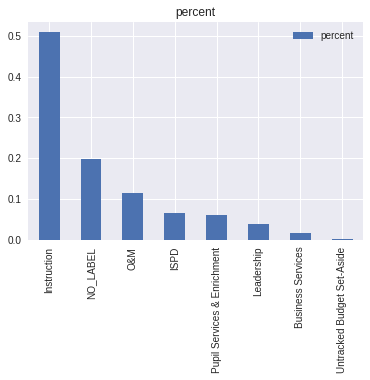

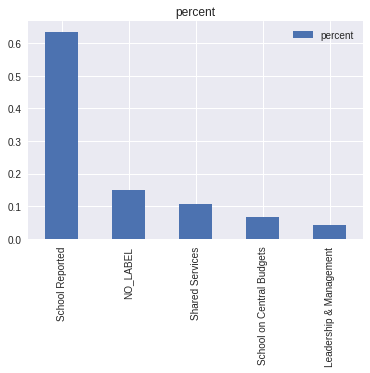

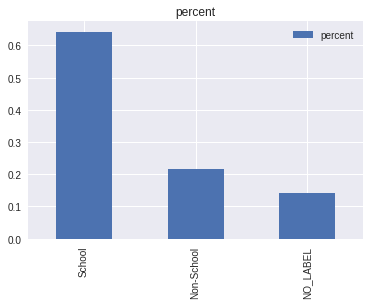

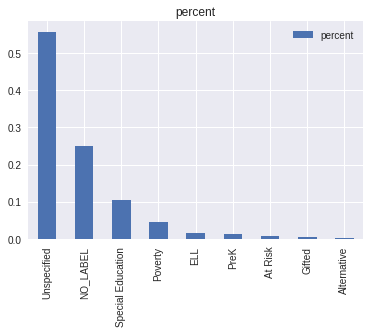

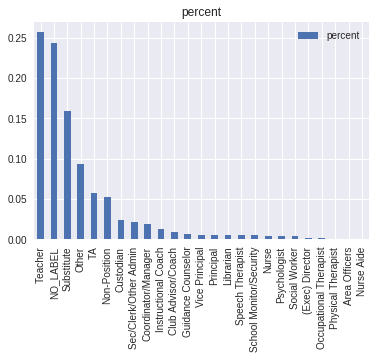

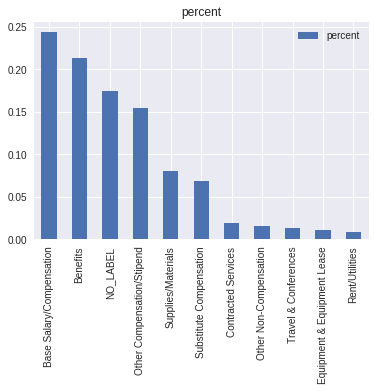

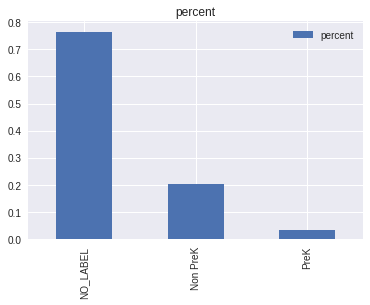

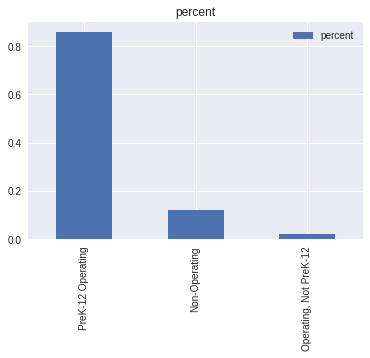

In [32]:
def value_counts(col):
    counts = budget_train[col].value_counts()
    percent = budget_train[col].value_counts(normalize=True)
    return pd.DataFrame({'percent': percent})

for i, col in enumerate(budget_train[targets]):
    col = value_counts(col)
    col.plot(kind='bar', subplots=True)

The target percentages/graphs show that there is high class inbalance within each of the label so accuracy scores would not be sufficient to measure model predictions. The competition uses log_loss score to evaluate models so that is what I will use for models.

### Text Cleaning

Since this is treated as an NLP problem, some text cleaning were required before preprocessing the data for modeling. 

In [ ]:
# turns all capitalized leter to lower
for col in budget_df[word_predictors]:
    budget_df[col] = budget_df[col].str.lower()
    
# use regex to remove any non alphanumeric characters and extra spaces
def cleaner(text):
    text = re.sub('[^a-zA-Z0-9]',' ',text)
    text = re.sub("\\s+", " ", text)
    text = ' '.join(i.lemma_ for i in nlp(text)
                    if i.orth_ not in STOP_WORDS)
    return text
#apply function to all the word predictor columns

for col in budget_df[word_predictors]:
    budget_df[col] = budget_df[col].apply(cleaner)

## Part 2: Create Baseline Model Pipeline

In [2]:
%run ../__init__.py

To create a model pipeline, I used feature union to combine 14 text columns with TfiDIF Vectorizor with ngrams of (1,2) and min_df of 10. I built 9 model pipelines, one for each label and treated each target problem as its own multi-class classification problem.

WhenI ran the model with all features including the numeric columns, the accuracy scores decreased and the log_loss increased. Therefore, I decided to not include numeric columns in the final model.

In [6]:
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    Parameters
     ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

# feature union transformer list 

transformer_list = [
    ('Object_Description', Pipeline([
                ('selector', ItemSelector(key='Object_Description')),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), token_pattern='(?u)\\b\\w\\w+\\b',min_df=10)),
            ])),
    ('Text_2', Pipeline([
                ('selector', ItemSelector(key='Text_2')),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), token_pattern='(?u)\\b\\w\\w+\\b',min_df=10)),
            ])),
    ('SubFund_Description', Pipeline([
                ('selector', ItemSelector(key='SubFund_Description')),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), token_pattern='(?u)\\b\\w\\w+\\b',min_df=10)),
            ])),
    ('Job_Title_Description', Pipeline([
                ('selector', ItemSelector(key='Job_Title_Description')),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), token_pattern='(?u)\\b\\w\\w+\\b',min_df=10)),
            ])),
    ('Text_3', Pipeline([
                ('selector', ItemSelector(key='Text_3')),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), token_pattern='(?u)\\b\\w\\w+\\b',min_df=10)),
            ])),
    ('Text_4', Pipeline([
                ('selector', ItemSelector(key='Text_4')),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), token_pattern='(?u)\\b\\w\\w+\\b',min_df=10)),
            ])),
    ('Sub_Object_Description', Pipeline([
                ('selector', ItemSelector(key='Sub_Object_Description')),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), token_pattern='(?u)\\b\\w\\w+\\b',min_df=10)),
            ])),
    ('Location_Description', Pipeline([
                ('selector', ItemSelector(key='Location_Description')),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), token_pattern='(?u)\\b\\w\\w+\\b',min_df=10)),
            ])),
    ('Function_Description', Pipeline([
                ('selector', ItemSelector(key='Function_Description')),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), token_pattern='(?u)\\b\\w\\w+\\b',min_df=10)),
            ])),
    ('Facility_or_Department', Pipeline([
                ('selector', ItemSelector(key='Facility_or_Department')),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), token_pattern='(?u)\\b\\w\\w+\\b',min_df=10)),
            ])),
    ('Position_Extra', Pipeline([
                ('selector', ItemSelector(key='Position_Extra')),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), token_pattern='(?u)\\b\\w\\w+\\b',min_df=10)),
            ])),
    ('Program_Description', Pipeline([
                ('selector', ItemSelector(key='Program_Description')),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), token_pattern='(?u)\\b\\w\\w+\\b',min_df=10)),
            ])),
    ('Fund_Description', Pipeline([
                ('selector', ItemSelector(key='Fund_Description')),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), token_pattern='(?u)\\b\\w\\w+\\b',min_df=10)),
            ])),
    ('Text_1', Pipeline([
                ('selector', ItemSelector(key='Text_1')),
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), token_pattern='(?u)\\b\\w\\w+\\b',min_df=10)),
            ]))
]

In [ ]:
def nlp_pipe(target_name,X, y):
     
    X_train, X_val, y_train, y_val = train_test_split(X, 
                                                    y, 
                                                    test_size=.2, 
                                                    random_state=42)
        
    pipeline = Pipeline([
    ("union", FeatureUnion(transformer_list=transformer_list)),
    ("clf", LogisticRegression())])

    
    model = pipeline.fit(X_train, y_train)
  
    val_proba = model.predict_proba(X_val)
    
    log_loss_score = log_loss(y_val, val_proba)
    
    results = {'target': target_name,
               'train_score': model.score(X_train, y_train),
               'val_score': model.score(X_val, y_val),
              'log_loss': log_loss_score}
    
    return model, results

In [ ]:
# for loop to run multiple models at once
model_results = []
for target in budget_train[targets]:
    X = budget_train[word_predictors] 
    y = label.fit_transform(budget_train[target])
    results = nlp_pipe(target,X, y)
    print(target)
    model_results.append(results)

Using pipeline that included FeatureUnion and Logistic Regression, I found the baseline scores for all models below: 

In [3]:
pd.read_pickle('../ipynb/baseline_results.pkl')

,log_loss,target,train_score,val_score
0,0.162338,Function,0.959334,0.955106
1,0.122412,Use,0.967894,0.965187
2,0.098230,Sharing,0.972385,0.971095
3,0.064400,Reporting,0.981047,0.980301
4,0.079315,Student_Type,0.977956,0.975405
5,0.070038,Position_Type,0.983090,0.981138
6,0.055530,Object_Type,0.985635,0.983949
7,0.032124,Pre_K,0.989944,0.989183
8,0.047490,Operating_Status,0.985282,0.984461


In [14]:
# submission sample:
initial_submission = pd.read_csv('../data/initial_submission.csv')

initial_submission.head(5)

,Unnamed: 0,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,...,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
0,180042,0.003283,0.000518,0.000011,0.000254,0.000604,0.000052,0.003436,0.000141,0.006110,...,0.001721,0.924427,0.000143,0.000068,6.153240e-02,0.001846,0.008714,0.926854,0.000552,0.000291
1,28872,0.000119,0.001974,0.000316,0.002526,0.009157,0.000286,0.372243,0.000882,0.098478,...,0.000734,0.965758,0.013244,0.002784,8.000000e-07,0.019666,0.002323,0.004965,0.956896,0.000120
2,186915,0.057924,0.002755,0.000063,0.002482,0.002392,0.000102,0.001242,0.000675,0.013308,...,0.002389,0.933597,0.000191,0.001015,6.463573e-01,0.099765,0.005735,0.224456,0.022409,0.000072
3,412396,0.058561,0.002759,0.000063,0.002485,0.002395,0.000102,0.001243,0.000674,0.013332,...,0.002398,0.933965,0.000190,0.001015,6.502231e-01,0.097776,0.005651,0.223204,0.021870,0.000071
4,427740,0.000459,0.015215,0.000142,0.000264,0.003094,0.000145,0.023989,0.000053,0.018626,...,0.000846,0.993008,0.015002,0.002917,8.300000e-06,0.848026,0.000187,0.087558,0.046257,0.000046


## Part 3: Model Tuning/Stacking/Boosting Methods to improve log loss scores

### Gridsearch to tune C
After finding the baseline scores, I did a gridsearch for best C values and found that C=10.0 decreased the log_scores slightly for each label.  However, when I combined the predict_proba for a second submission, **the total log_loss score went up to 1.0779** and I'm not sure why this is the case. 

In [9]:
pd.read_pickle('../ipynb/models/lrc_results.pkl')

,log_loss,target,train_score,val_score
0,0.136228,Function,0.965305,0.959566
1,0.106920,Use,0.972104,0.968122
2,0.086858,Sharing,0.976001,0.974243
3,0.058025,Reporting,0.982924,0.981838
4,0.069994,Student_Type,0.980107,0.977191
5,0.056051,Position_Type,0.986003,0.983274
6,0.047173,Object_Type,0.987262,0.985123
7,0.029622,Pre_K,0.990685,0.989695
8,0.044087,Operating_Status,0.986309,0.985098


### XGB-Boosting
Since the baseline model and the model with C=10 already produced pretty decent scores, I decided to do some extreme boosting methods to see if I could improve the scores even more. The pipelines for XGB-boost were built with the same method as above.

In [ ]:
def xgb_pipe(target_name,X, y):
     
    X_train, X_val, y_train, y_val = train_test_split(X, 
                                                    y, 
                                                    test_size=.2, 
                                                    random_state=42)
        
    pipeline = Pipeline([
    ("union", FeatureUnion(transformer_list=transformer_list)),
    ("clf", xgb.XGBClassifier())])

    
    model = pipeline.fit(X_train, y_train)
   
    val_proba = model.predict_proba(X_val)
    
    log_loss_score = log_loss(y_val, val_proba)
    
    results = {'target': target_name,
               'train_score': model.score(X_train, y_train),
               'val_score': model.score(X_val, y_val),
              'log_loss': log_loss_score}
    
    return model, results

Surprisingly, XGB-boost increased the log_scores for all models. This is an area that I want to explore further to better understand why boosting method did not improve overall scores.

In [8]:
pd.read_pickle('../ipynb/models/xgb_results.pkl')

,log_loss,target,train_score,val_score
0,0.340313,Function,0.928665,0.925640
1,0.390550,Use,0.898817,0.895748
2,0.325791,Sharing,0.912535,0.912224
3,0.230643,Reporting,0.943914,0.943352
4,0.236016,Student_Type,0.944935,0.943227
5,0.186560,Position_Type,0.959731,0.957805
6,0.193116,Object_Type,0.965212,0.963788
7,0.071374,Pre_K,0.982490,0.981750
8,0.100120,Operating_Status,0.972606,0.972095


## Blended Models

After running a few tests with other ensemble methods (RandomForest, Adaboost), I found that the two logistic regression models still produced the lowest log loss scores. Therefore, I decided to try to blend the results through a RandomForest model. As a result of the blended models, the log_loss scores decreased for all columns.

**I couldn't build this blended model as a function due to limited computing power/memory space so I ran each model individually in separate Jupyter notebooks**.
Below is an example of the codes on how I built the blended models for one label.

In [ ]:
#Example of blended model for Operating Status
label = LabelEncoder()
X_test = budget_test

#create sub data sets for blendedmodels
X_train = budget_train[word_predictors] 
y_train = label.fit_transform(budget_train['Operating_Status'])
X_sub_1, X_sub_2, y_sub_1, y_sub_2 = train_test_split(X_train,y_train, test_size = .5, random_state = 42)
X_test = budget_test

#first layer models
lr_pipe_1 = Pipeline([
    ("union", FeatureUnion(transformer_list=transformer_list)),
    ("clf", LogisticRegression())])

lr_pipe_2 = Pipeline([
    ("union", FeatureUnion(transformer_list=transformer_list)),
    ("clf", LogisticRegression(C=10))])

#fit models on first subset 
lr_pipe_1.fit(X_sub_1,y_sub_1)
lr_pipe_2.fit(X_sub_1,y_sub_1)
   
#predict proba on second subset of data and blend the results together 
lr1_train_predict = lr_pipe_1.predict_proba(X_sub_2)
lr2_train_predict = lr_pipe_2.predict_proba(X_sub_2)
blended = np.concatenate([lr1_train_predict, lr2_train_predict], axis=1)


# get predict_proba test_set and combine results together 
lr1_test_predict = lr_pipe_1.predict_proba(X_test)
lr2_test_predict = lr_pipe_2.predict_proba(X_test)
test_combine_pred = np.concatenate([lr1_test_predict, lr2_test_predict], axis=1)

#fit blended predict_probas and y_sub_2 in blender model
blender = RandomForestClassifier()
blender.fit(blended, y_sub_2)

# get predict proba of the blended result from blender model
train_prediction = blender.predict_proba(blended)

log_loss_score = log_loss(y_sub_2, train_prediction)

# get predict_proba of blended test set from blender model
test_blended_proba = blender.predict_proba(test_combine_pred)

**Below is the log_loss scores of the blended models**

In [15]:
pd.read_pickle('../ipynb/blended_scores.pkl')

,log_loss,target
0,0.023484,Operating_Status
1,0.013780,Pre_K
2,0.039473,Use
3,0.035260,Sharing
4,0.030682,Reporting
5,0.063606,Function
6,0.032353,Student_Type
7,0.022934,Object_Type
8,0.021866,Position_Type


## Further Explorations

While my validation sets show lower log_loss scores with the blended models, when I tried the same method for the test_set for submission to the competition, the total log_loss scores went up. I need the further explore why the blended models are not performing as well on the test set. Some initial thoughts of why this happened is that my model could be overfitting with Randomforest so a few thoughts for next steps:
-  try a simpler model for the blender to avoid over-fitting
-  try to diversify base models (instead of two logistic regression)
-  try a wider range of C values of the two base logistic regression models
- try sklearn multi-layer perceptron